In [1]:
import numpy as np  # NumPy kütüphanesini import et, matematiksel işlemler için kullanılır.
import pandas as pd  # Pandas kütüphanesini import et, veri manipülasyonu ve analizi için kullanılır.
import tensorflow as tf  # TensorFlow kütüphanesini import et, derin öğrenme ve makine öğrenmesi için kullanılır.
import nltk  # NLTK (Natural Language Toolkit) kütüphanesini import et, doğal dil işleme için kullanılır.
from nltk.corpus import stopwords  # NLTK'dan stopwords (durum sözcükleri) veri kümesini import et.
from sklearn.model_selection import train_test_split  # Veriyi eğitim ve test setlerine ayırmak için kullanılır.
from tensorflow.keras.preprocessing.text import Tokenizer  # Keras'ın Tokenizer sınıfını import et, metin verisini sayısal verilere dönüştürmek için.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Metin dizilerini sabit uzunlukta pad etmek için kullanılır.
from tensorflow.keras.models import Sequential  # Keras'ta sıralı modeller oluşturmak için kullanılır.
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Bidirectional, LSTM, Dense, Dropout, Input  # Keras katmanlarını import et, sinir ağı oluşturmak için kullanılır.
from tensorflow.keras.callbacks import EarlyStopping  # Eğitim sırasında erken durdurma için kullanılır.
from tensorflow.keras.optimizers import Adam  # Adam optimizasyon algoritmasını import et.
from sklearn.metrics import accuracy_score, precision_score, recall_score  # Model değerlendirmesi için doğruluk, hassasiyet ve duyarlılık skorları hesaplamak için kullanılır.
import random  # Rastgele sayılar ve seçimler yapmak için kullanılır.
import pickle  # Python objelerini dosyaya kaydetmek ve yüklemek için kullanılır.

nltk.download('stopwords')  # NLTK'dan stopwords veri kümesini indir.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Veri Yükleme
dogru_haberler_path = "C:\\Users\\Lenovo\OneDrive\\Masaüstü\\sahte haber\\dogru_haberler.csv"
sahte_haberler_path = "C:\\Users\\Lenovo\OneDrive\\Masaüstü\\sahte haber\\sahte_haberler.csv"
df_dogru = pd.read_csv(dogru_haberler_path, sep=';')
df_sahte = pd.read_csv(sahte_haberler_path, sep=';')

In [3]:
# Etiketler: 1 -> Doğru, 0 -> Sahte
df_dogru['ETİKET'] = 1
df_sahte['ETİKET'] = 0

In [4]:
print(df_dogru.columns)  # 'df_dogru' DataFrame'inin sütun isimlerini yazdır.
print(df_dogru.head())  # 'df_dogru' DataFrame'inin ilk 5 satırını yazdır.
print(len(df_dogru))  # 'df_dogru' DataFrame'inin toplam satır sayısını yazdır.

Index(['HABER', 'ETİKET'], dtype='object')
                                               HABER  ETİKET
0  Sağlık Bilimleri Üniversitesi, Osmanlı'nın mod...       1
1  Kozmetik Üreticileri ve Araştırma Derneği (KÜA...       1
2  Türk Silahlı Kuvvetlerinin (TSK) keskin nişanc...       1
3  Soru güvenliğindeki sorunlar nedeniyle bu yılk...       1
4  Cumhurbaşkanlığı İletişim Başkanı Fahrettin Al...       1
449


In [5]:
print(df_sahte.columns)  # 'df_sahte' DataFrame'inin sütun isimlerini yazdır.
print(df_sahte.head())  # 'df_sahte' DataFrame'inin ilk 5 satırını yazdır.
print(len(df_sahte))  # 'df_sahte' DataFrame'inin toplam satır sayısını yazdır.

Index(['HABER', 'ETİKET'], dtype='object')
                                               HABER  ETİKET
0  Ziraat Bankası, 2024'ün ilk 10 ayında "kurum z...       0
1  Temmuz ayında gerçekleştirilen Pençe-Kilit ope...       0
2  Türkiye Diyanet Vakfı'nın bağış ve zekat gelir...       0
3  Kanser tedavisinde devrim yaratacağı öne sürül...       0
4  Bu yılki üniversite sınavı, soru güvenliğiyle ...       0
464


In [6]:
df = pd.concat([df_dogru, df_sahte]).reset_index(drop=True)  # 'df_dogru' ve 'df_sahte' DataFrame'lerini birleştirir ve indeksleri sıfırlar.
df  # Birleştirilmiş DataFrame'i görüntüler.

,HABER,ETİKET
0,"Sağlık Bilimleri Üniversitesi, Osmanlı'nın mod...",1
1,Kozmetik Üreticileri ve Araştırma Derneği (KÜA...,1
2,Türk Silahlı Kuvvetlerinin (TSK) keskin nişanc...,1
3,Soru güvenliğindeki sorunlar nedeniyle bu yılk...,1
4,Cumhurbaşkanlığı İletişim Başkanı Fahrettin Al...,1
...,...,...
908,Afrikada yoldan geçen minübüsü devasa bir pito...,0
909,Edirne belediyesi tarafından her ilçeye soğuk ...,0
910,Eline makineli tüfek verilen bir maymun tüfeği...,0
911,10 yıl önce bir kaza sonucu düşen ve enkazı b...,0


In [7]:
# Türkçe stopwords ve Stanza ile lemmatizasyon
nltk.download('stopwords')  # NLTK'dan Türkçe stopwords listesini indir.
stop_words = stopwords.words('turkish')  # Türkçe stopwords listesini al.
stop_words.extend(['bir', 've', 'ile', 'diğer', 'olarak', 'gibi', 'ancak'])  # Ekstra stopwords ekle.

import stanza  # Stanza kütüphanesini import et, dil işleme için kullanılır.
stanza.download('tr')  # Stanza'dan Türkçe modelini indir.
nlp = stanza.Pipeline('tr', processors='tokenize,mwt,pos,lemma')  
# Türkçe dil işleme boru hattını başlat, tokenization, mwt, part-of-speech (POS) etiketleme ve lemmatizasyon işlemleri yapılacak.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2025-01-12 19:32:15 INFO: Downloaded file to C:\Users\Lenovo\stanza_resources\resources.json
2025-01-12 19:32:15 INFO: Downloading default packages for language: tr (Turkish) ...
2025-01-12 19:32:15 INFO: File exists: C:\Users\Lenovo\stanza_resources\tr\default.zip
2025-01-12 19:32:18 INFO: Finished downloading models and saved to C:\Users\Lenovo\stanza_resources
2025-01-12 19:32:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-01-12 19:32:18 INFO: Downloaded file to C:\Users\Lenovo\stanza_resources\resources.json
2025-01-12 19:32:19 INFO: Loading these models for language: tr (Turkish):
| Processor | Package       |
-----------------------------
| tokenize  | imst          |
| mwt       | imst          |
| pos       | imst_charlm   |
| lemma     | imst_nocharlm |

2025-01-12 19:32:19 INFO: Using device: cpu
2025-01-12 19:32:19 INFO: Loading: tokenize
2025-01-12 19:32:21 INFO: Loading: mwt
2025-01-12 19:32:21 INFO: Loading: pos
2025-01-12 19:32:24 INFO: Loading: lemma
2025-01-12 19:32:24 INFO: Done loading processors!


In [8]:
def preprocess_and_lemmatize(text):
    if not isinstance(text, str):  # Eğer verilen metin bir string (metin) değilse, boş liste döndür.
        return []  # NaN veya yanlış tipteki verileri atmak için boş liste döner.
    result = []  # Sonuçları depolamak için boş bir liste oluştur.
    doc = nlp(text)  # Stanza boru hattını kullanarak metni analiz et (tokenization, POS etiketleme ve lemmatizasyon yap).
    for sentence in doc.sentences:  # Her bir cümleyi iterasyonla geç.
        for word in sentence.words:  # Cümledeki her kelimeyi iterasyonla geç.
            lemma = word.lemma  # Kelimenin kökünü (lemma) al.
            if lemma and lemma not in stop_words and len(lemma) > 2:  # Eğer kök var, stopwords (duru sözcükler) içinde değilse ve uzunluğu 2'den büyükse,
                result.append(lemma)  # Kökü sonuç listesine ekle.
    return result  # Temizlenmiş ve lemmatize edilmiş kelimelerle oluşan listeyi döndür.

# Metinlerin temizlenmesi
df['clean_haber'] = df['HABER'].apply(preprocess_and_lemmatize)  # 'HABER' sütunundaki her bir metni temizle ve lemmatize et, sonucu 'clean_haber' sütununa yaz.
df['clean_joined_haber'] = df['clean_haber'].apply(lambda x: " ".join(x)) 
# 'clean_haber' sütunundaki kelimeleri birleştir, her kelime arasına boşluk koyarak 'clean_joined_haber' sütununa yaz.

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk

# Stopwords (dahil edilmemesi gereken yaygın kelimeler)
stop_words = set(['ve', 'bir', 'bu', 'için', 'ile', 'dedi.', 'yeni', 'Başkanı', 'olarak', 'en'])

# Tüm haber metinlerini birleştirip tokenlara ayırıyoruz
all_words = " ".join(df['HABER']).split()

# Kelimelerin sıklığını sayıyoruz
word_counts = Counter(all_words)

# Sıklığı 10'dan fazla olan kelimeleri seçiyoruz, stopwords'leri hariç tutuyoruz
filtered_words = {word: count for word, count in word_counts.items() if count > 10 and word not in stop_words}


In [32]:
# Veri Augmentasyonu (Veri artırma)
def augment_data(text, num_augmented=3):
    augmented_texts = []  # Artırılmış metinleri depolayacak boş bir liste oluştur.
    for _ in range(num_augmented):  # 'num_augmented' kadar döngü çalıştır, bu sayı kadar artırılmış metin oluştur.
        words = text.split()  # Metni kelimelere ayır.
        random.shuffle(words)  # Kelimeleri rastgele karıştır.
        augmented_texts.append(" ".join(words))  # Karıştırılmış kelimeleri birleştirerek yeni bir metin oluştur ve listeye ekle.
    return augmented_texts  # Artırılmış metinlerin listesini döndür.

augmented_data = []  # Artırılmış metinlerin verilerini depolayacak boş bir liste oluştur.
augmented_labels = []  # Artırılmış metinlerin etiketlerini depolayacak boş bir liste oluştur.
for i, row in df.iterrows():  # Veri çerçevesindeki her bir satırı iterasyonla geç.
    augmented_texts = augment_data(row['clean_joined_haber'])  # Satırdaki temizlenmiş ve birleştirilmiş metni artır.
    augmented_data.extend(augmented_texts)  # Artırılmış metinleri 'augmented_data' listesine ekle.
    augmented_labels.extend([row['ETİKET']] * len(augmented_texts))  # Her artırılmış metin için etiketleri 'augmented_labels' listesine ekle.

df_augmented = pd.DataFrame({'clean_joined_haber': augmented_data, 'ETİKET': augmented_labels}) 
# Artırılmış veriler ve etiketlerle yeni bir DataFrame oluştur.

In [25]:
# Eğitim ve test verilerine ayırma
X = df_augmented['clean_joined_haber']
y = df_augmented['ETİKET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Metin verisini sayısal verilere dönüştürme
max_vocab = 10000  # En fazla 10.000 kelimeyi dikkate alacak şekilde bir değişken oluştur.
tokenizer = Tokenizer(num_words=max_vocab)  
# Tokenizer nesnesini oluştur, num_words parametresiyle yalnızca en sık kullanılan 'max_vocab' sayıda kelimeyi al.
tokenizer.fit_on_texts(X_train)  
# 'X_train' veri setindeki metinleri kullanarak tokenizer'ı eğit, kelimeleri sayarak sıralar.

In [27]:
X_train_seq = tokenizer.texts_to_sequences(X_train)  # 'X_train' veri setindeki metinleri sayılara (indekslere) dönüştür.
X_test_seq = tokenizer.texts_to_sequences(X_test)  # 'X_test' veri setindeki metinleri sayılara (indekslere) dönüştür.

In [28]:
# Giriş verisinin işlenmesi
MAX_SEQUENCE_LENGTH = 100  # Örneğin, 100 kelimelik sabit uzunluk
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Metinleri sekansa çevir
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)  # Sabit uzunlukta doldur

In [29]:
# Padding (Dizileri sabit uzunluğa getirme)
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=256)  
# Eğitim setindeki dizileri sabit uzunlukta 256'ya getir, eksik olan yerleri 'post' (dizinin sonuna) ekle.
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=256)  
# Test setindeki dizileri sabit uzunlukta 256'ya getir, eksik olan yerleri 'post' (dizinin sonuna) ekle.

In [30]:
# Modelin oluşturulması
model = Sequential([  # Sequential modeli başlat, modeldeki katmanlar sırasıyla eklenecek.
    Embedding(input_dim=max_vocab, output_dim=128),  # Embedding katmanı: Her kelimeyi 128 boyutlu bir vektöre dönüştür, 'max_vocab' kadar kelimeyi kabul et.
    Conv1D(64, 5, activation='relu'),  # 1D Konvolüsyonel katman: 64 filtre ile 5 pencerelik bir konvolüsyon uygular, 'relu' aktivasyon fonksiyonu kullanır.
    MaxPool1D(pool_size=4),  # Max Pooling katmanı: 4 uzunluğundaki pencerelerle en yüksek değeri seçer, modelin boyutunu küçültür.
    Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM katmanı: 64 birimlik LSTM, sıralı veriyi ileri ve geri yönde işler, her zaman diziyi döndürür.
    Bidirectional(LSTM(16)),  # Bidirectional LSTM katmanı: 16 birimlik LSTM, ileri ve geri yönlü analiz yapar, son çıktıyı alır.
    Dense(64, activation='relu'),  # Tam bağlantılı katman: 64 nöronlu bir dense katman, 'relu' aktivasyon fonksiyonu ile.
    Dropout(0.5),  # Dropout katmanı: Aşırı öğrenmeyi önlemek için her 2 nörondan birini rastgele kapatır, %50 dropout oranı ile.
    Dense(1, activation='sigmoid')  # Çıktı katmanı: Tek bir çıkış nöronu, 'sigmoid' aktivasyonu ile 0 ya da 1 değerini tahmin eder (ikili sınıflandırma için).
])

In [31]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])  # Erken durdurma (early stopping) kullanarak modelin aşırı uyum yapmasını engelleme


In [18]:
# Erken durdurma (early stopping) kullanarak modelin aşırı uyum yapmasını engelleme
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
history = model.fit(X_train_pad, y_train,
                    validation_split=0.20, 
                    epochs=15, 
                    batch_size=32, 
                    callbacks=[early_stop])  


Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.5014 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5482 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5166 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5582 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5791 - loss: 0.6882 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5479 - loss: 0.6854 - val_accuracy: 0.5000 - val_loss: 0.6898
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6072 - loss: 0.6813 - val_accuracy: 0.5548 - val_loss: 0.6865
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7071 - loss: 0.6697 - val_accuracy: 0.5890 -

In [20]:
# Modelin kaydedilmesi
model.save('fake_news_model.h5')

In [21]:
# Tokenizer'ı kaydetme
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# Model değerlendirmesi
pred = model.predict(X_test_pad)
binary_predictions = (pred >= 0.5).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


In [23]:
# Değerlendirme metrikleri
print('Accuracy:', accuracy_score(y_test, binary_predictions))
print('Precision:', precision_score(y_test, binary_predictions))
print('Recall:', recall_score(y_test, binary_predictions))
print('Precision on testing set:', precision_score(binary_predictions, y_test))  

Accuracy: 0.8032786885245902
Precision: 0.7843137254901961
Recall: 0.851063829787234
Precision on testing set: 0.851063829787234


In [48]:
y_pred = (model.predict(X_test_padded) > 0.5).astype(int)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Tahminlerin değerlendirilmesi
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[210  66]
 [ 31 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       276
           1       0.79      0.89      0.83       272

    accuracy                           0.82       548
   macro avg       0.83      0.82      0.82       548
weighted avg       0.83      0.82      0.82       548



In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

# X_test'i işleme
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Test verisini sekansa çevir
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)  # Doldur

# Tahminleri al
y_pred = (model.predict(X_test_padded) > 0.5).astype(int)

# Hata matrisi ve sınıflandırma raporu
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Confusion Matrix:
[[210  66]
 [ 31 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       276
           1       0.79      0.89      0.83       272

    accuracy                           0.82       548
   macro avg       0.83      0.82      0.82       548
weighted avg       0.83      0.82      0.82       548



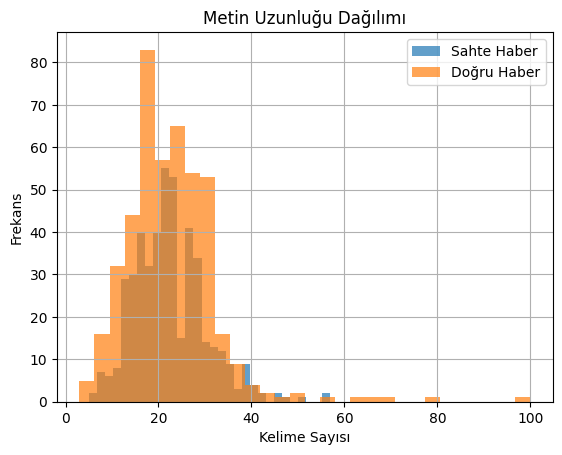

In [51]:
import matplotlib.pyplot as plt

df['text_length'] = df['HABER'].apply(lambda x: len(x.split()))
df[df['ETİKET'] == 0]['text_length'].hist(bins=30, alpha=0.7, label='Sahte Haber')
df[df['ETİKET'] == 1]['text_length'].hist(bins=30, alpha=0.7, label='Doğru Haber')
plt.legend()
plt.title("Metin Uzunluğu Dağılımı")
plt.xlabel("Kelime Sayısı")
plt.ylabel("Frekans")
plt.show()

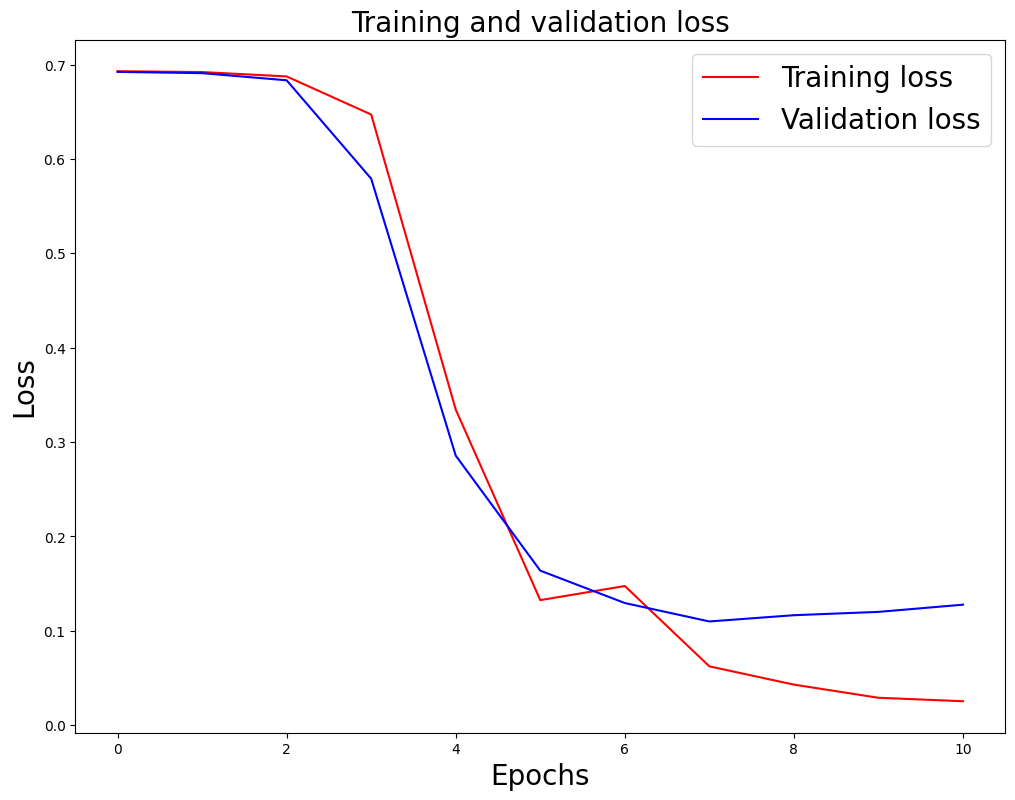

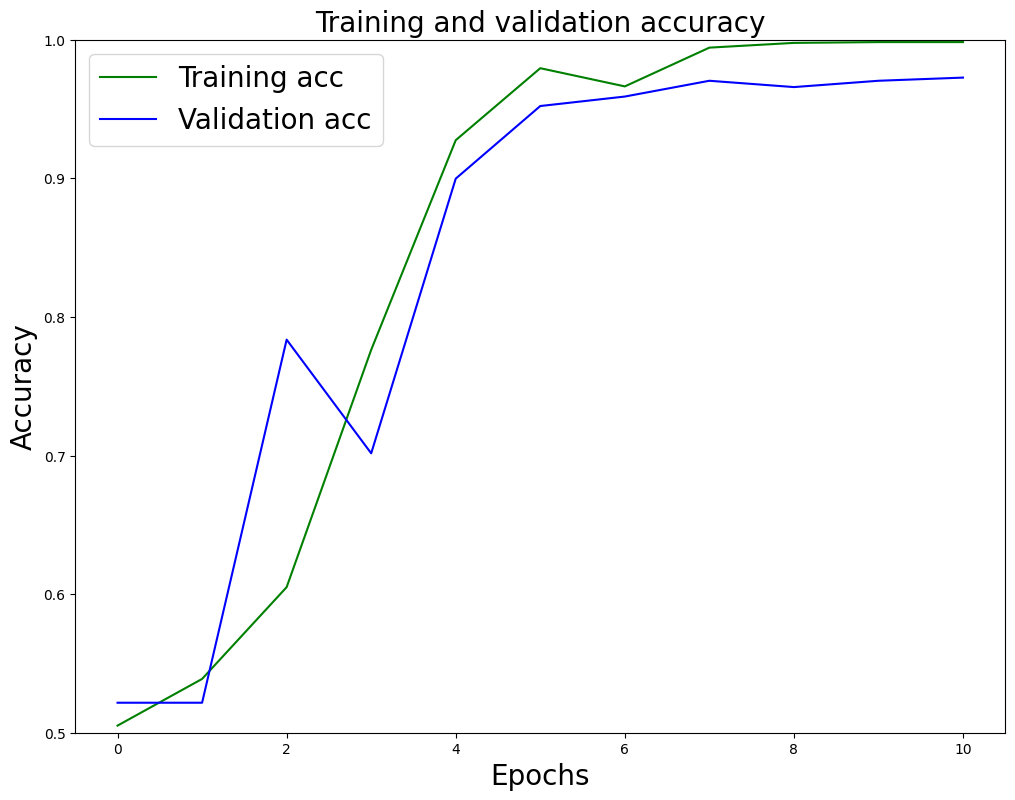

In [52]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()
